
---
# DỰ ÁN COMPUTER VISION - PHÂN LOẠI LỖI BỀ MẶT TỪ ẢNH SEM
NEU Surface Defect Database Classification

MÔ TẢ BÀI TOÁN:
- Phân loại 6 loại lỗi bề mặt thép: Crazing, Inclusion, Patches,
  Pitted Surface, Rolled-in Scale, Scratches
- Dataset: NEU Surface Defect Database với 1800 ảnh grayscale 200x200px
- Mục tiêu: So sánh hiệu suất của EfficientNet, MobileNet, và ResNet

HƯỚNG DẪN CHẠY TRÊN GOOGLE COLAB:
1. Tải dataset từ Kaggle hoặc nguồn khác
2. Upload lên Google Drive hoặc tải trực tiếp
3. Chạy từng cell theo thứ tự
4. Kết quả sẽ được lưu vào thư mục outputs/
---

## BƯỚC 1: CÀI ĐẶT THƯ VIỆN VÀ IMPORT

In [1]:
!pip install -q kaggle tensorflow-addons scikit-plot

ERROR: Could not find a version that satisfies the requirement tensorflow-addons (from versions: none)
ERROR: No matching distribution found for tensorflow-addons


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import (
    EfficientNetB0, EfficientNetB3, EfficientNetB7,
    MobileNet, MobileNetV2, MobileNetV3Small, MobileNetV3Large,
    ResNet50V2
)
import time
import json
from datetime import datetime

# Thiết lập seed để tái tạo kết quả
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


---
## BƯỚC 2: TẢI DATASET TỪ KAGGLE (Tùy chọn)

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kaustubhdikshit/neu-surface-defect-database")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'neu-surface-defect-database' dataset.
Path to dataset files: /kaggle/input/neu-surface-defect-database


In [4]:
OUTPUT_DIR = Path("/kaggle/outputs")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

---
## BƯỚC 3: KHỞI TẠO THƯ MỤC VÀ THAM SỐ

In [5]:
# Classes trong NEU Surface Defect Database
CLASSES = ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches']
NUM_CLASSES = len(CLASSES)

print(f"Number of classes: {NUM_CLASSES}")
print(f"Classes: {CLASSES}")

Number of classes: 6
Classes: ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches']


In [6]:
DATA_PATH = "/kaggle/input/neu-surface-defect-database"

# Reset image_data for fresh population
image_data = []

# Base directory where NEU-DET is unzipped
base_det_dir = os.path.join(DATA_PATH, "NEU-DET")

# Subdirectories that contain image folders (e.g., 'train', 'validation')
sub_data_types = ['train', 'validation']

print("Đang thu thập dữ liệu ảnh...")
for data_type in sub_data_types:
    current_images_root = os.path.join(base_det_dir, data_type, "images")
    if os.path.exists(current_images_root):
        print(f"  Tìm kiếm trong: {current_images_root}")
        for class_name in CLASSES:
            class_dir = os.path.join(current_images_root, class_name)
            if os.path.exists(class_dir):
                images = [f for f in os.listdir(class_dir) if f.endswith(('.jpg', '.png', '.bmp'))]
                for img_name in images:
                    image_data.append({
                        'filename': img_name,
                        'filepath': os.path.join(class_dir, img_name),
                        'class': class_name,
                        'class_idx': CLASSES.index(class_name)
                    })
            else:
                print(f"  Warning: Thư mục lớp {class_dir} không tìm thấy. Bỏ qua.")
    else:
        print(f"  Warning: Thư mục ảnh {current_images_root} không tìm thấy. Bỏ qua.")

df = pd.DataFrame(image_data)

print(f"\nTổng số ảnh đã thu thập: {len(df)}")
print(f"Số lớp: {NUM_CLASSES}")

print("\nPhân bố dữ liệu:")
if not df.empty and 'class' in df.columns:
    print(df['class'].value_counts())
else:
    print("Không có dữ liệu ảnh nào được tìm thấy hoặc DataFrame trống sau khi thu thập.")
    print("Vui lòng kiểm tra lại cấu trúc thư mục dữ liệu.")

Đang thu thập dữ liệu ảnh...
  Tìm kiếm trong: /kaggle/input/neu-surface-defect-database/NEU-DET/train/images
  Tìm kiếm trong: /kaggle/input/neu-surface-defect-database/NEU-DET/validation/images

Tổng số ảnh đã thu thập: 1800
Số lớp: 6

Phân bố dữ liệu:
class
crazing            300
inclusion          300
patches            300
pitted_surface     300
rolled-in_scale    300
scratches          300
Name: count, dtype: int64


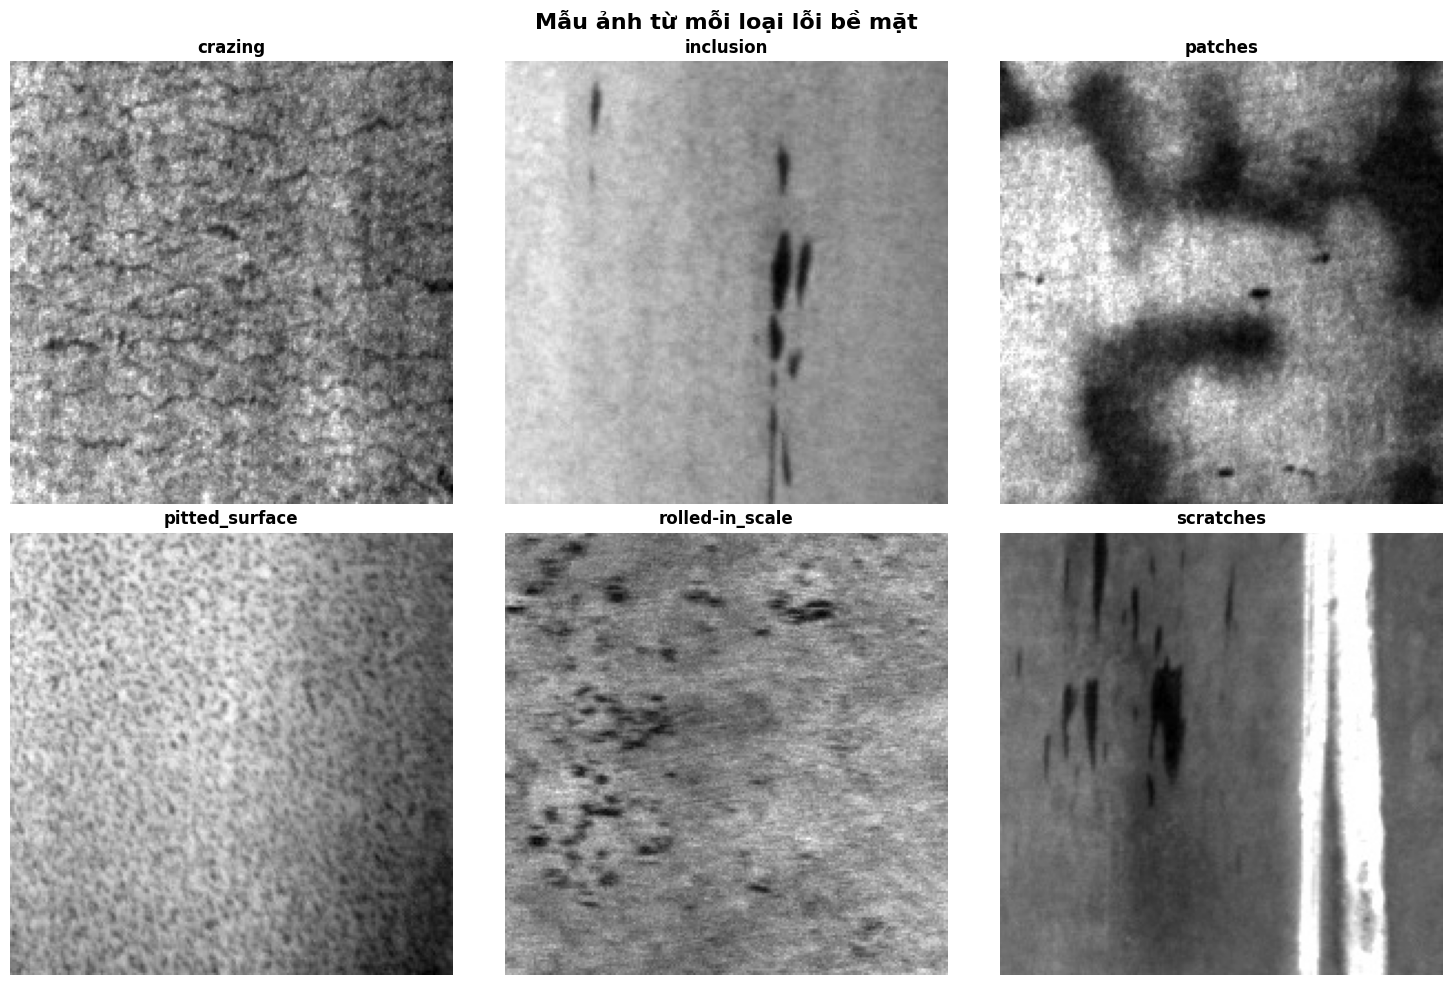

In [31]:
from PIL import Image

# Hiển thị mẫu ảnh
sample_images = df.groupby('class').first()
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Mẫu ảnh từ mỗi loại lỗi bề mặt', fontsize=16, fontweight='bold')

for idx, (class_name, row) in enumerate(sample_images.iterrows()):
    ax = axes[idx // 3, idx % 3]
    img = Image.open(row['filepath']).convert('L')  # Grayscale
    ax.imshow(img, cmap='gray')
    ax.set_title(f'{class_name}', fontsize=12, fontweight='bold')
    ax.axis('off')

plt.tight_layout()
plt.show()

---
## BƯỚC 4: TIỀN XỬ LÝ ẢNH ĐẶC BIỆT CHO ẢNH SEM

In [7]:
def preprocess_sem_image(image_path, target_size=(224, 224)):
    """
    Tiền xử lý ảnh SEM với các kỹ thuật đặc biệt:
    - CLAHE (Contrast Limited Adaptive Histogram Equalization)
    - Gaussian blur để giảm nhiễu
    - Normalization
    """
    # Đọc ảnh
    img = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)

    # CLAHE để cải thiện contrast
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img = clahe.apply(img)

    # Giảm nhiễu với Gaussian Blur
    img = cv2.GaussianBlur(img, (3, 3), 0)

    # Resize
    img = cv2.resize(img, target_size)

    # Chuyển sang 3 kênh (RGB) cho pre-trained models
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    # Normalization [0, 255] -> [0, 1]
    img = img.astype(np.float32) / 255.0

    return img

In [ ]:
def load_dataset_from_directory(data_dir, classes):
    """
    Tải dataset từ cấu trúc thư mục
    Giả định cấu trúc: data_dir/class_name/image.jpg
    """
    images = []
    labels = []

    for idx, class_name in enumerate(classes):
        class_dir = data_dir / class_name
        if not class_dir.exists():
            print(f"Warning: Directory {class_dir} not found!")
            continue

        image_files = list(class_dir.glob('*.bmp')) + list(class_dir.glob('*.jpg')) + list(class_dir.glob('*.png'))

        print(f"Loading {len(image_files)} images from {class_name}...")

        for img_path in image_files:
            img = preprocess_sem_image(img_path, IMG_SIZE)
            images.append(img)
            labels.append(idx)

    return np.array(images), np.array(labels)

---
## BƯỚC 5: TẢI VÀ CHIA DỮ LIỆU

In [10]:
# Tham số huấn luyện
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 1e-4

In [11]:
print("Loading dataset from DataFrame...")
images_list = []
labels_list = []

# Iterate through the pre-collected dataframe which has all correct filepaths
for index, row in df.iterrows():
    img_path = row['filepath']
    class_idx = row['class_idx']
    img = preprocess_sem_image(img_path, IMG_SIZE)
    images_list.append(img)
    labels_list.append(class_idx)

X = np.array(images_list)
y = np.array(labels_list)

print(f"Successfully loaded {len(X)} images.")

Loading dataset from DataFrame...
Successfully loaded 1800 images.


In [12]:
print(f"\nDataset shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Unique labels: {np.unique(y)}")


Dataset shape: (1800, 224, 224, 3)
Labels shape: (1800,)
Unique labels: [0 1 2 3 4 5]


In [13]:
# Phân chia dữ liệu: 70% train, 15% validation, 15% test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"\nTrain set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")


Train set: 1260 samples
Validation set: 270 samples
Test set: 270 samples


In [14]:
# Chuyển labels sang one-hot encoding
y_train_cat = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_val_cat = keras.utils.to_categorical(y_val, NUM_CLASSES)
y_test_cat = keras.utils.to_categorical(y_test, NUM_CLASSES)

---
## BƯỚC 6: DATA AUGMENTATION

In [15]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2,
    shear_range=0.15,
    fill_mode='reflect'
)

val_datagen = ImageDataGenerator()  # Không augment validation set

---
## BƯỚC 7: XÂY DỰNG MODELS

In [16]:
def create_model(base_model_name='EfficientNetB0', input_shape=(224, 224, 3)):
    """
    Tạo model với transfer learning
    """
    # Chọn base model
    if base_model_name == 'EfficientNetB0':
        base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base_model_name == 'EfficientNetB3':
        base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base_model_name == 'EfficientNetB7':
        base_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base_model_name == 'MobileNet':
        base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base_model_name == 'MobileNetV2':
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base_model_name == 'MobileNetV3Small':
        base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base_model_name == 'MobileNetV3Large':
        base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base_model_name == 'ResNet50V2':
        base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=input_shape)
    else:
        raise ValueError(f"Unknown model: {base_model_name}")

    # Freeze base model layers
    base_model.trainable = False

    # Tạo model
    inputs = keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

    model = keras.Model(inputs, outputs)

    return model

---
## BƯỚC 8: HÀM HUẤN LUYỆN VÀ ĐÁNH GIÁ

In [17]:
def train_and_evaluate_model(model_name, X_train, y_train, X_val, y_val, X_test, y_test):
    """
    Huấn luyện và đánh giá một model
    """
    print(f"\n{'='*80}")
    print(f"Training {model_name}")
    print(f"{'='*80}")

    # Tạo model
    model = create_model(model_name, input_shape=(*IMG_SIZE, 3))

    # Compile model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss='categorical_crossentropy',
        metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()]
    )

    print(f"\nModel: {model_name}")
    print(f"Total parameters: {model.count_params():,}")

    # Callbacks
    checkpoint_path = OUTPUT_DIR / f"{model_name}_best.keras"
    callbacks = [
        ModelCheckpoint(checkpoint_path, monitor='val_accuracy',
                       save_best_only=True, mode='max', verbose=1),
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1)
    ]

    # Training
    start_time = time.time()

    history = model.fit(
        train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
        validation_data=(X_val, y_val),
        epochs=EPOCHS,
        callbacks=callbacks,
        verbose=1
    )

    training_time = time.time() - start_time

    # Load best weights
    model.load_weights(checkpoint_path)

    # Evaluation
    print(f"\nEvaluating {model_name} on test set...")
    test_loss, test_acc, test_precision, test_recall = model.evaluate(X_test, y_test, verbose=0)

    # Predictions
    y_pred_probs = model.predict(X_test, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Classification report
    report = classification_report(y_true, y_pred, target_names=CLASSES, output_dict=True)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Results summary
    results = {
        'model_name': model_name,
        'test_accuracy': float(test_acc),
        'test_precision': float(test_precision),
        'test_recall': float(test_recall),
        'test_loss': float(test_loss),
        'training_time': training_time,
        'total_parameters': int(model.count_params()),
        'classification_report': report,
        'confusion_matrix': cm.tolist()
    }

    print(f"\n{model_name} Results:")
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test Precision: {test_precision:.4f}")
    print(f"Test Recall: {test_recall:.4f}")
    print(f"Training Time: {training_time:.2f}s")

    return model, history, results

---
## BƯỚC 9: HUẤN LUYỆN TẤT CẢ MODELS

In [18]:
# Danh sách models cần so sánh
MODELS_TO_TRAIN = [
    'EfficientNetB0',
    'EfficientNetB3',
    'MobileNet',
    'MobileNetV2',
    'MobileNetV3Small',
    # 'MobileNetV3Large',
    'ResNet50V2'
]

all_results = {}
all_histories = {}
# `trained_models` will not store actual model objects across iterations due to memory management (tf.keras.backend.clear_session()).
# Instead, the best weights for each model are saved as .keras files and can be reloaded.

print(f"\n{'='*80}")
print(f"Starting training for {len(MODELS_TO_TRAIN)} models")
print(f"Models to train: {MODELS_TO_TRAIN}")
print(f"{'='*80}\n")

for model_name in MODELS_TO_TRAIN:
    try:
        model, history, results = train_and_evaluate_model(
            model_name,
            X_train, y_train_cat,
            X_val, y_val_cat,
            X_test, y_test_cat
        )

        all_results[model_name] = results
        all_histories[model_name] = history.history

        # Lưu kết quả riêng lẻ của model
        with open(OUTPUT_DIR / f'{model_name}_results.json', 'w') as f:
            json.dump(results, f, indent=4)
        print(f"  Individual results for {model_name} saved to {OUTPUT_DIR / f'{model_name}_results.json'}")

        # Lưu lịch sử huấn luyện riêng lẻ của model
        with open(OUTPUT_DIR / f'{model_name}_history.json', 'w') as f:
            json.dump(history.history, f, indent=4)
        print(f"  Individual history for {model_name} saved to {OUTPUT_DIR / f'{model_name}_history.json'}")

        # Giải phóng bộ nhớ
        del model
        tf.keras.backend.clear_session()

    except Exception as e:
        print(f"Error training {model_name}: {str(e)}")
        continue

# Lưu tổng hợp tất cả các kết quả và lịch sử sau khi tất cả models đã được huấn luyện
try:
    with open(OUTPUT_DIR / 'all_results_summary.json', 'w') as f:
        json.dump(all_results, f, indent=4)
    print(f"\nConsolidated results summary saved to {OUTPUT_DIR / 'all_results_summary.json'}")

    with open(OUTPUT_DIR / 'all_histories_summary.json', 'w') as f:
        json.dump(all_histories, f, indent=4)
    print(f"Consolidated histories summary saved to {OUTPUT_DIR / 'all_histories_summary.json'}")

except Exception as e:
    print(f"Error saving consolidated results/histories: {str(e)}")


Starting training for 6 models
Models to train: ['EfficientNetB0', 'EfficientNetB3', 'MobileNet', 'MobileNetV2', 'MobileNetV3Small', 'ResNet50V2']


Training EfficientNetB0
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

Model: EfficientNetB0
Total parameters: 4,416,297


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 804ms/step - accuracy: 0.1848 - loss: 1.9964 - precision: 0.2102 - recall: 0.0141
Epoch 1: val_accuracy improved from -inf to 0.16667, saving model to /kaggle/outputs/EfficientNetB0_best.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.1848 - loss: 1.9954 - precision: 0.2110 - recall: 0.0141 - val_accuracy: 0.1667 - val_loss: 1.8000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - accuracy: 0.1583 - loss: 1.9574 - precision: 0.0913 - recall: 0.0048
Epoch 2: val_accuracy did not improve from 0.16667
40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 386ms/step - accuracy: 0.1584 - loss: 1.9570 - precision: 0.0917 - recall: 0.0048 - val_accuracy: 0.1667 - val_loss: 1.7944 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.1838 - loss: 1.8807 - precision: 0.3364 - recall: 0.0084


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



EfficientNetB0 Results:
Test Accuracy: 0.2556
Test Precision: 0.0000
Test Recall: 0.0000
Training Time: 827.50s
  Individual results for EfficientNetB0 saved to /kaggle/outputs/EfficientNetB0_results.json
  Individual history for EfficientNetB0 saved to /kaggle/outputs/EfficientNetB0_history.json

Training EfficientNetB3
43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

Model: EfficientNetB3
Total parameters: 11,216,821


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2398 - loss: 1.8936 - precision: 0.3178 - recall: 0.0493
Epoch 1: val_accuracy improved from -inf to 0.16667, saving model to /kaggle/outputs/EfficientNetB3_best.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 0.2401 - loss: 1.8918 - precision: 0.3187 - recall: 0.0495 - val_accuracy: 0.1667 - val_loss: 1.7725 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.2797 - loss: 1.7108 - precision: 0.4090 - recall: 0.0765
Epoch 2: val_accuracy improved from 0.16667 to 0.18148, saving model to /kaggle/outputs/EfficientNetB3_best.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 18s 440ms/step - accuracy: 0.2800 - loss: 1.7099 - precision: 0.4095 - recall: 0.0767 - val_accuracy: 0.1815 - val_loss: 1.7550 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



EfficientNetB3 Results:
Test Accuracy: 0.5852
Test Precision: 0.7826
Test Recall: 0.1333
Training Time: 918.18s
  Individual results for EfficientNetB3 saved to /kaggle/outputs/EfficientNetB3_results.json
  Individual history for EfficientNetB3 saved to /kaggle/outputs/EfficientNetB3_history.json

Training MobileNet
17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

Model: MobileNet
Total parameters: 3,529,030


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 596ms/step - accuracy: 0.2348 - loss: 2.1070 - precision: 0.2789 - recall: 0.1048
Epoch 1: val_accuracy improved from -inf to 0.63704, saving model to /kaggle/outputs/MobileNet_best.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 48s 902ms/step - accuracy: 0.2365 - loss: 2.1007 - precision: 0.2816 - recall: 0.1057 - val_accuracy: 0.6370 - val_loss: 1.3522 - val_precision: 1.0000 - val_recall: 0.0741 - learning_rate: 1.0000e-04
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.5373 - loss: 1.3021 - precision: 0.6687 - recall: 0.2932
Epoch 2: val_accuracy improved from 0.63704 to 0.94815, saving model to /kaggle/outputs/MobileNet_best.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 15s 370ms/step - accuracy: 0.5384 - loss: 1.2987 - precision: 0.6701 - recall: 0.2946 - val_accuracy: 0.9481 - val_loss: 0.9502 - val_precision: 1.0000 - val_recall: 0.1778 - learning_rate: 1.0000e-04
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.7098 - loss: 0.87

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 577ms/step - accuracy: 0.3054 - loss: 2.1598 - precision: 0.3567 - recall: 0.1897
Epoch 1: val_accuracy improved from -inf to 0.71481, saving model to /kaggle/outputs/MobileNetV2_best.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 52s 925ms/step - accuracy: 0.3084 - loss: 2.1494 - precision: 0.3605 - recall: 0.1920 - val_accuracy: 0.7148 - val_loss: 1.0381 - val_precision: 0.9268 - val_recall: 0.2815 - learning_rate: 1.0000e-04
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.7085 - loss: 0.8269 - precision: 0.8080 - recall: 0.5705
Epoch 2: val_accuracy improved from 0.71481 to 0.88519, saving model to /kaggle/outputs/MobileNetV2_best.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 15s 371ms/step - accuracy: 0.7096 - loss: 0.8249 - precision: 0.8086 - recall: 0.5720 - val_accuracy: 0.8852 - val_loss: 0.5842 - val_precision: 0.9583 - val_recall: 0.6815 - learning_rate: 1.0000e-04
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.8346 - loss: 

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 547ms/step - accuracy: 0.2545 - loss: 1.7038 - precision: 0.6727 - recall: 0.0215
Epoch 1: val_accuracy improved from -inf to 0.16667, saving model to /kaggle/outputs/MobileNetV3Small_best.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 49s 865ms/step - accuracy: 0.2561 - loss: 1.7020 - precision: 0.6781 - recall: 0.0221 - val_accuracy: 0.1667 - val_loss: 1.7919 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.4302 - loss: 1.4763 - precision: 0.8658 - recall: 0.0999
Epoch 2: val_accuracy improved from 0.16667 to 0.24444, saving model to /kaggle/outputs/MobileNetV3Small_best.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 15s 369ms/step - accuracy: 0.4309 - loss: 1.4751 - precision: 0.8661 - recall: 0.1002 - val_accuracy: 0.2444 - val_loss: 1.7757 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step -

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 541ms/step - accuracy: 0.2383 - loss: 2.1312 - precision: 0.2407 - recall: 0.0746
Epoch 1: val_accuracy improved from -inf to 0.60370, saving model to /kaggle/outputs/ResNet50V2_best.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 47s 813ms/step - accuracy: 0.2402 - loss: 2.1249 - precision: 0.2442 - recall: 0.0758 - val_accuracy: 0.6037 - val_loss: 1.4399 - val_precision: 1.0000 - val_recall: 0.0148 - learning_rate: 1.0000e-04
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.5426 - loss: 1.2612 - precision: 0.6671 - recall: 0.2706
Epoch 2: val_accuracy improved from 0.60370 to 0.87037, saving model to /kaggle/outputs/ResNet50V2_best.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 17s 418ms/step - accuracy: 0.5445 - loss: 1.2574 - precision: 0.6698 - recall: 0.2726 - val_accuracy: 0.8704 - val_loss: 1.0994 - val_precision: 1.0000 - val_recall: 0.1630 - learning_rate: 1.0000e-04
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.7449 - loss: 0.

---
## BƯỚC 10: VISUALIZATION VÀ SO SÁNH KẾT QUẢ

In [19]:
def plot_training_history(histories, metric='accuracy'):
    """Vẽ biểu đồ quá trình training"""
    plt.figure(figsize=(15, 5))

    for model_name, history in histories.items():
        plt.plot(history[metric], label=f'{model_name} train')
        plt.plot(history[f'val_{metric}'], label=f'{model_name} val', linestyle='--')

    plt.title(f'Training and Validation {metric.capitalize()}')
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / f'training_{metric}.png', dpi=300, bbox_inches='tight')
    plt.show()

In [20]:
def plot_comparison_metrics(results):
    """So sánh các metrics giữa các models"""
    models = list(results.keys())
    accuracies = [results[m]['test_accuracy'] for m in models]
    precisions = [results[m]['test_precision'] for m in models]
    recalls = [results[m]['test_recall'] for m in models]

    x = np.arange(len(models))
    width = 0.25

    fig, ax = plt.subplots(figsize=(14, 6))
    ax.bar(x - width, accuracies, width, label='Accuracy', alpha=0.8)
    ax.bar(x, precisions, width, label='Precision', alpha=0.8)
    ax.bar(x + width, recalls, width, label='Recall', alpha=0.8)

    ax.set_xlabel('Models')
    ax.set_ylabel('Score')
    ax.set_title('Model Performance Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=45, ha='right')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'models_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

In [21]:
def plot_confusion_matrices(results, classes):
    """Vẽ confusion matrices cho tất cả models"""
    n_models = len(results)
    fig, axes = plt.subplots(2, (n_models + 1) // 2, figsize=(20, 10))
    axes = axes.flatten()

    for idx, (model_name, result) in enumerate(results.items()):
        cm = np.array(result['confusion_matrix'])

        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=classes, yticklabels=classes,
                   ax=axes[idx], cbar_kws={'label': 'Count'})

        axes[idx].set_title(f'{model_name}\nAccuracy: {result["test_accuracy"]:.4f}')
        axes[idx].set_ylabel('True Label')
        axes[idx].set_xlabel('Predicted Label')

    # Hide unused subplots
    for idx in range(len(results), len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'confusion_matrices.png', dpi=300, bbox_inches='tight')
    plt.show()

In [22]:
def create_summary_table(results):
    """Tạo bảng tổng hợp kết quả"""
    summary_data = []

    for model_name, result in results.items():
        summary_data.append({
            'Model': model_name,
            'Accuracy': f"{result['test_accuracy']:.4f}",
            'Precision': f"{result['test_precision']:.4f}",
            'Recall': f"{result['test_recall']:.4f}",
            'Parameters': f"{result['total_parameters']:,}",
            'Training Time (s)': f"{result['training_time']:.2f}"
        })

    df = pd.DataFrame(summary_data)
    df = df.sort_values('Accuracy', ascending=False)

    print("\n" + "="*100)
    print("SUMMARY TABLE - MODEL COMPARISON")
    print("="*100)
    print(df.to_string(index=False))
    print("="*100)

    df.to_csv(OUTPUT_DIR / 'summary_results.csv', index=False)

    return df


Generating visualizations...


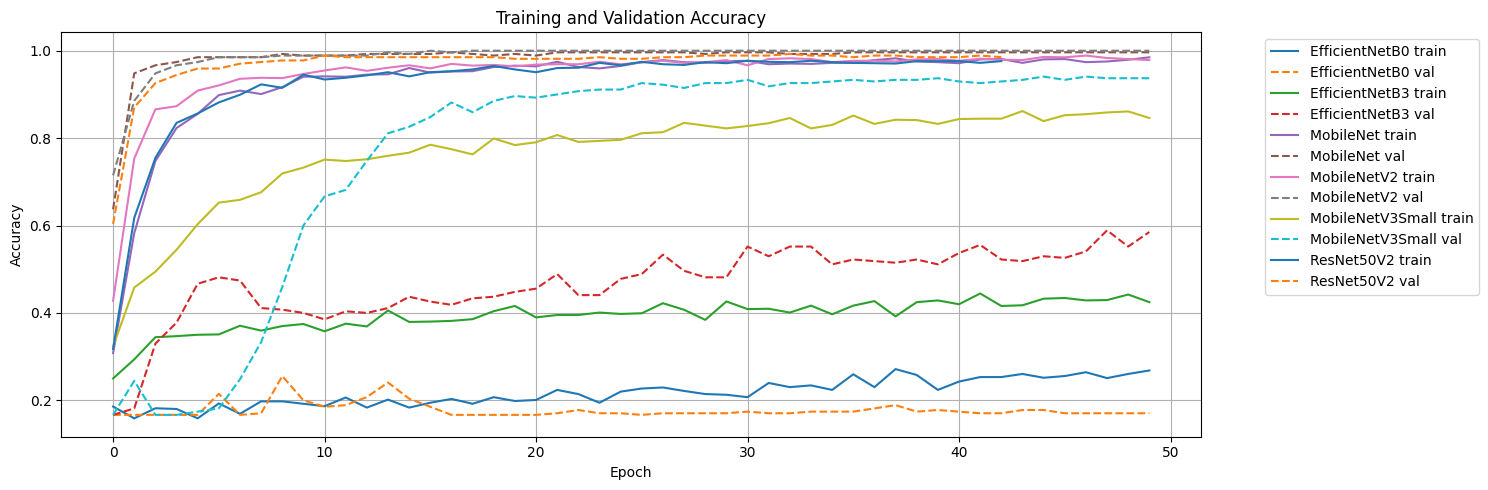

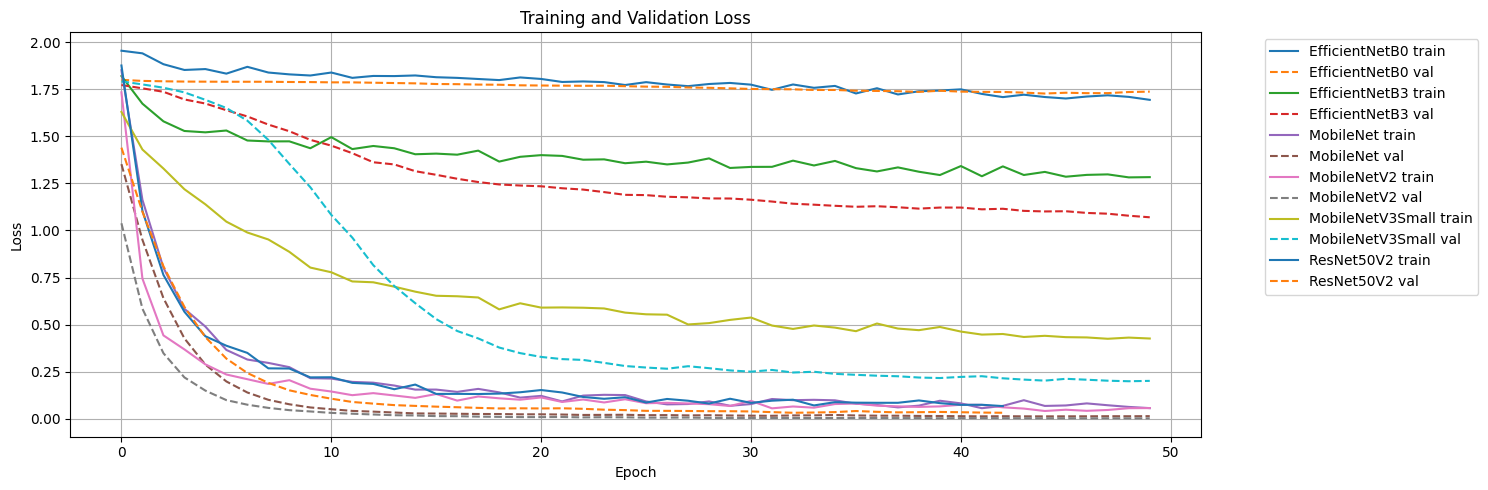

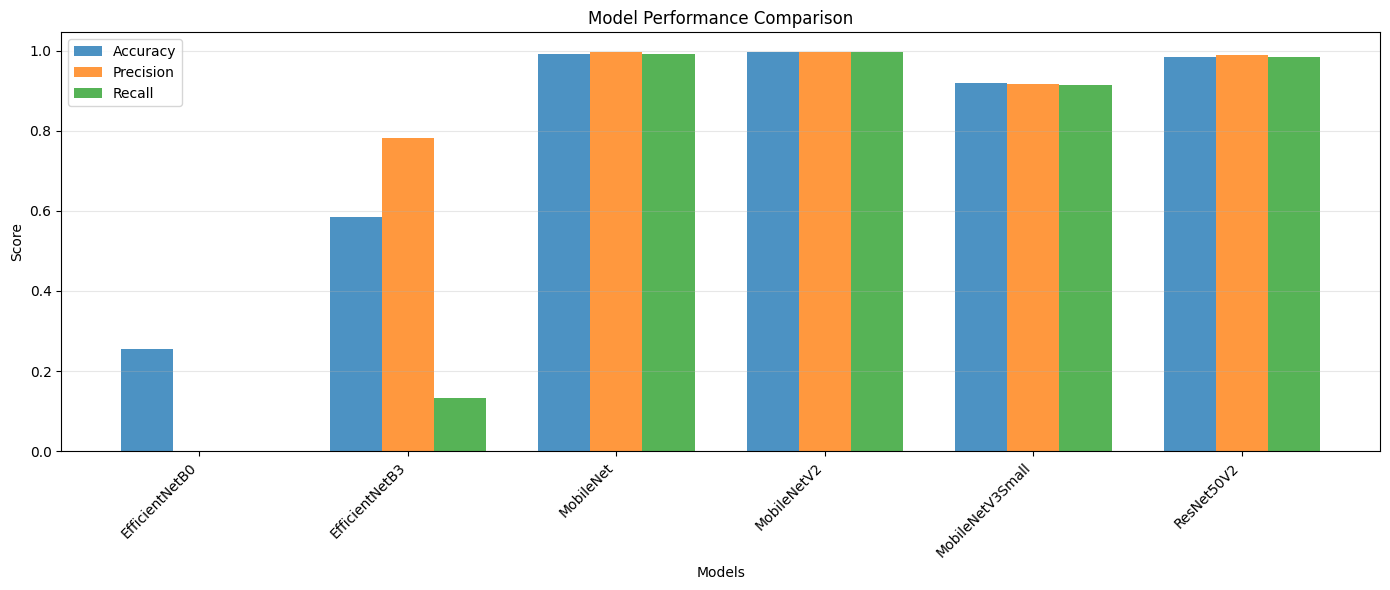

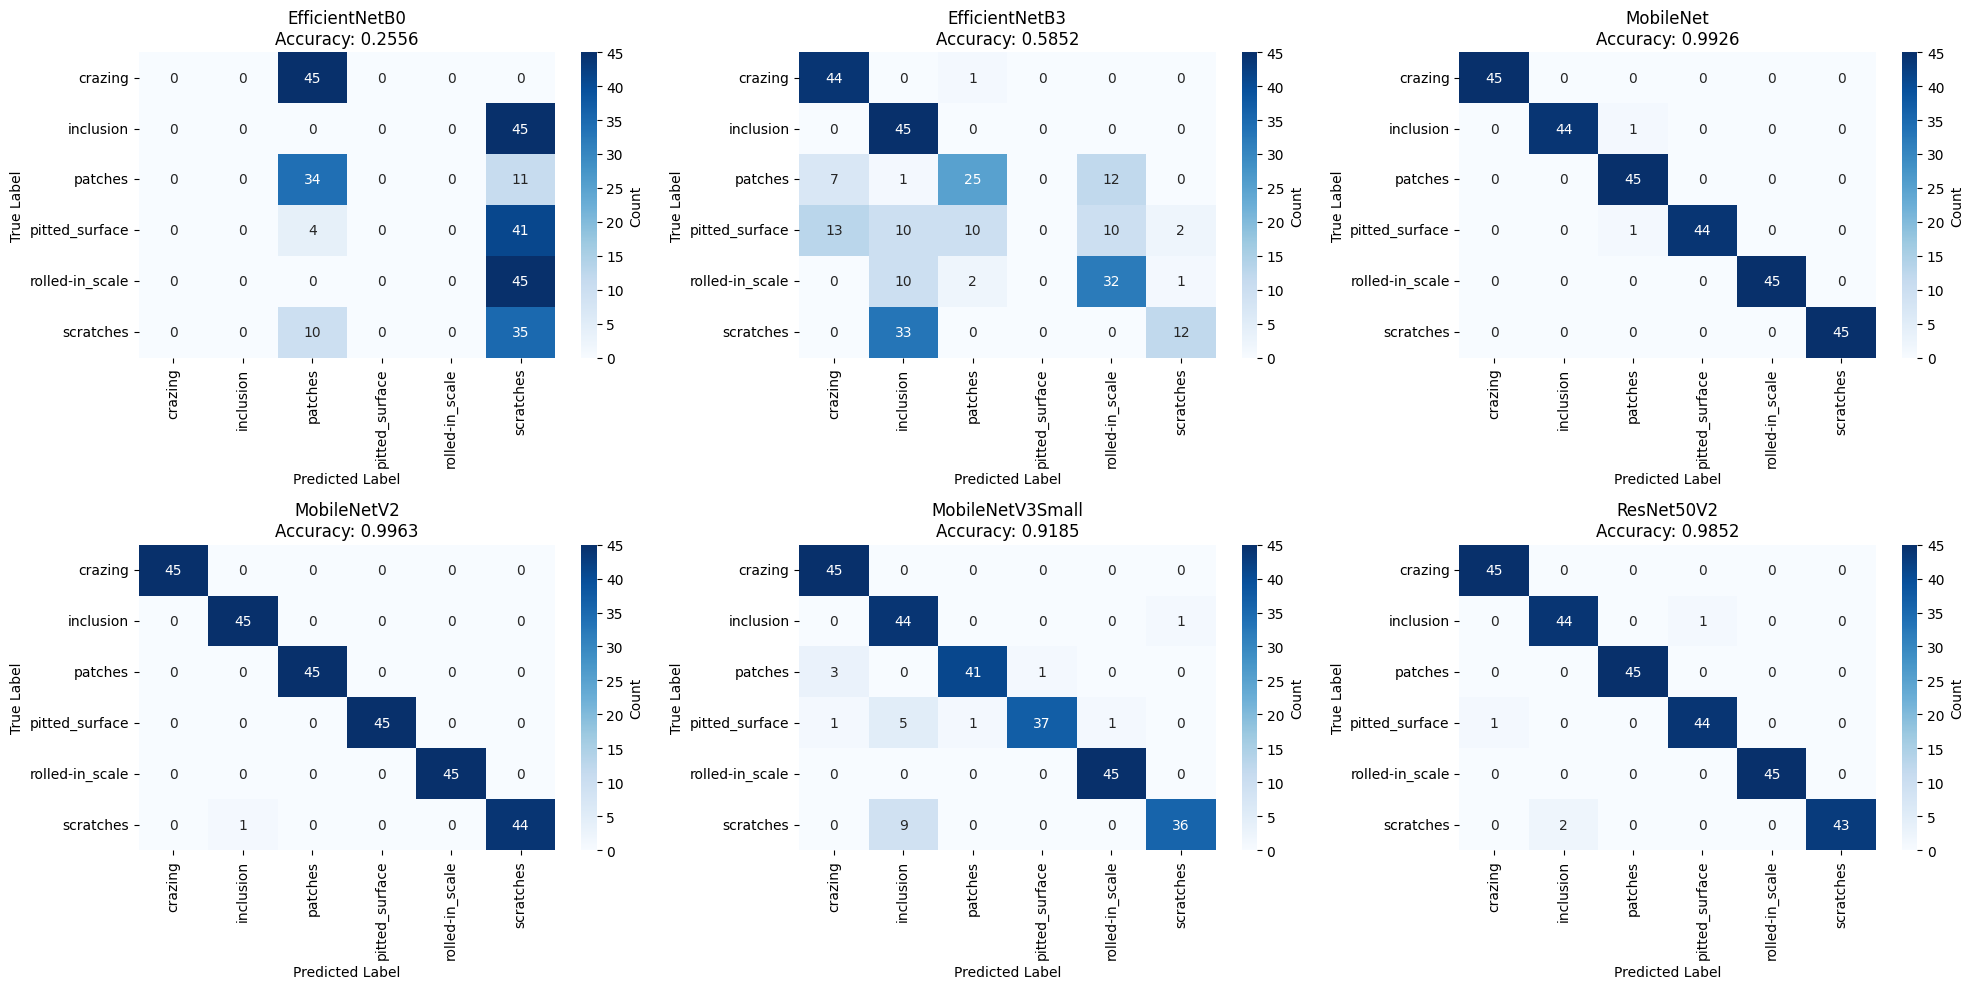


SUMMARY TABLE - MODEL COMPARISON
           Model Accuracy Precision Recall Parameters Training Time (s)
     MobileNetV2   0.9963    0.9963 0.9963  2,624,710            781.73
       MobileNet   0.9926    0.9963 0.9926  3,529,030            770.67
      ResNet50V2   0.9852    0.9888 0.9852 24,131,206            742.01
MobileNetV3Small   0.9185    0.9182 0.9148  1,122,806            776.44
  EfficientNetB3   0.5852    0.7826 0.1333 11,216,821            918.18
  EfficientNetB0   0.2556    0.0000 0.0000  4,416,297            827.50


In [23]:
# Vẽ các biểu đồ
print("\nGenerating visualizations...")
# Reload all_results and all_histories from files to ensure consistency after interruption
if 'all_results' not in globals() or not all_results:
    try:
        with open(OUTPUT_DIR / 'all_results_summary.json', 'r') as f:
            all_results = json.load(f)
        print("Loaded all_results from file.")
    except FileNotFoundError:
        print("Error: all_results_summary.json not found. Please ensure training completed or re-run training.")
        # Handle the error, maybe exit or use an empty dict
        all_results = {}

if 'all_histories' not in globals() or not all_histories:
    try:
        with open(OUTPUT_DIR / 'all_histories_summary.json', 'r') as f:
            all_histories = json.load(f)
        print("Loaded all_histories from file.")
    except FileNotFoundError:
        print("Error: all_histories_summary.json not found. Please ensure training completed or re-run training.")
        # Handle the error, maybe exit or use an empty dict
        all_histories = {}

# Filter out models that were interrupted or didn't finish training (if any)
finished_models_results = {k: v for k, v in all_results.items() if k in MODELS_TO_TRAIN}
finished_models_histories = {k: v for k, v in all_histories.items() if k in MODELS_TO_TRAIN}

if finished_models_results:
    plot_training_history(finished_models_histories, 'accuracy')
    plot_training_history(finished_models_histories, 'loss')
    plot_comparison_metrics(finished_models_results)
    plot_confusion_matrices(finished_models_results, CLASSES)
    summary_df = create_summary_table(finished_models_results)
else:
    print("No completed model results found for comparison.")


---
## BƯỚC 11: FINE-TUNING MODEL TỐT NHẤT (Tùy chọn)

In [24]:
def fine_tune_best_model(model, X_train, y_train, X_val, y_val):
    """
    Fine-tune model tốt nhất bằng cách unfreeze một số layers
    """
    print("\nFine-tuning best model...")

    # Unfreeze top layers
    base_model = model.layers[1]
    base_model.trainable = True

    # Freeze bottom layers
    for layer in base_model.layers[:-30]:
        layer.trainable = False

    # Compile với learning rate thấp hơn
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Fine-tune
    history = model.fit(
        train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
        validation_data=(X_val, y_val),
        epochs=20,
        callbacks=[
            EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)
        ]
    )

    return model, history

In [25]:
# Uncomment để fine-tune model tốt nhất

# Ensure all_results is populated, load from file if necessary
if 'all_results' not in globals() or not all_results:
    try:
        with open(OUTPUT_DIR / 'all_results_summary.json', 'r') as f:
            all_results = json.load(f)
        print("Loaded all_results from file for fine-tuning.")
    except FileNotFoundError:
        print("Error: all_results_summary.json not found. Please run model training first.")
        raise # Re-raise to stop execution if results are missing

best_model_name = max(all_results.items(), key=lambda x: x[1]['test_accuracy'])[0]
print(f"\nBest model: {best_model_name}")

# Re-create the model structure and load its best saved weights
best_model = create_model(best_model_name, input_shape=(*IMG_SIZE, 3))
best_model.load_weights(OUTPUT_DIR / f"{best_model_name}_best.keras") # Load from the best.keras file

best_model, ft_history = fine_tune_best_model(best_model, X_train, y_train_cat, X_val, y_val_cat)
best_model.save(OUTPUT_DIR / f'{best_model_name}_finetuned.keras')


Best model: MobileNetV2

Fine-tuning best model...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 50s 802ms/step - accuracy: 0.7351 - loss: 0.7769 - val_accuracy: 0.9778 - val_loss: 0.0532 - learning_rate: 1.0000e-05
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 391ms/step - accuracy: 0.8311 - loss: 0.4514 - val_accuracy: 0.9556 - val_loss: 0.1213 - learning_rate: 1.0000e-05
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.8804 - loss: 0.3515 - val_accuracy: 0.9481 - val_loss: 0.1886 - learning_rate: 1.0000e-05
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 15s 369ms/step - accuracy: 0.8925 - loss: 0.3141 - val_accuracy: 0.9407 - val_loss: 0.2389 - learning_rate: 1.0000e-05
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 15s 371ms/step - accuracy: 0.9136 - loss: 0.2484 - val_accuracy: 0.9370 - val_loss: 0.2776 - learning_rate: 5.0000e-06
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 15s 383ms/step - accuracy: 0.9209 - loss: 0.2457 - val_accuracy: 0.9333 - val_loss: 0.2987 - learning_rate: 5.0000e-06


---
## BƯỚC 12: DỰ ĐOÁN VÀ VISUALIZATION

In [26]:
def visualize_predictions(model, X_test, y_test, classes, num_samples=16):
    """Hiển thị một số predictions"""
    indices = np.random.choice(len(X_test), num_samples, replace=False)

    fig, axes = plt.subplots(4, 4, figsize=(16, 16))
    axes = axes.flatten()

    predictions = model.predict(X_test[indices], verbose=0)

    for idx, ax in enumerate(axes):
        img = X_test[indices[idx]]
        true_label = np.argmax(y_test[indices[idx]])
        pred_label = np.argmax(predictions[idx])
        confidence = predictions[idx][pred_label]

        ax.imshow(img)
        ax.axis('off')

        color = 'green' if true_label == pred_label else 'red'
        ax.set_title(f'True: {classes[true_label]}\n'
                    f'Pred: {classes[pred_label]}\n'
                    f'Conf: {confidence:.2f}',
                    color=color, fontsize=10)

    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'sample_predictions.png', dpi=300, bbox_inches='tight')
    plt.show()

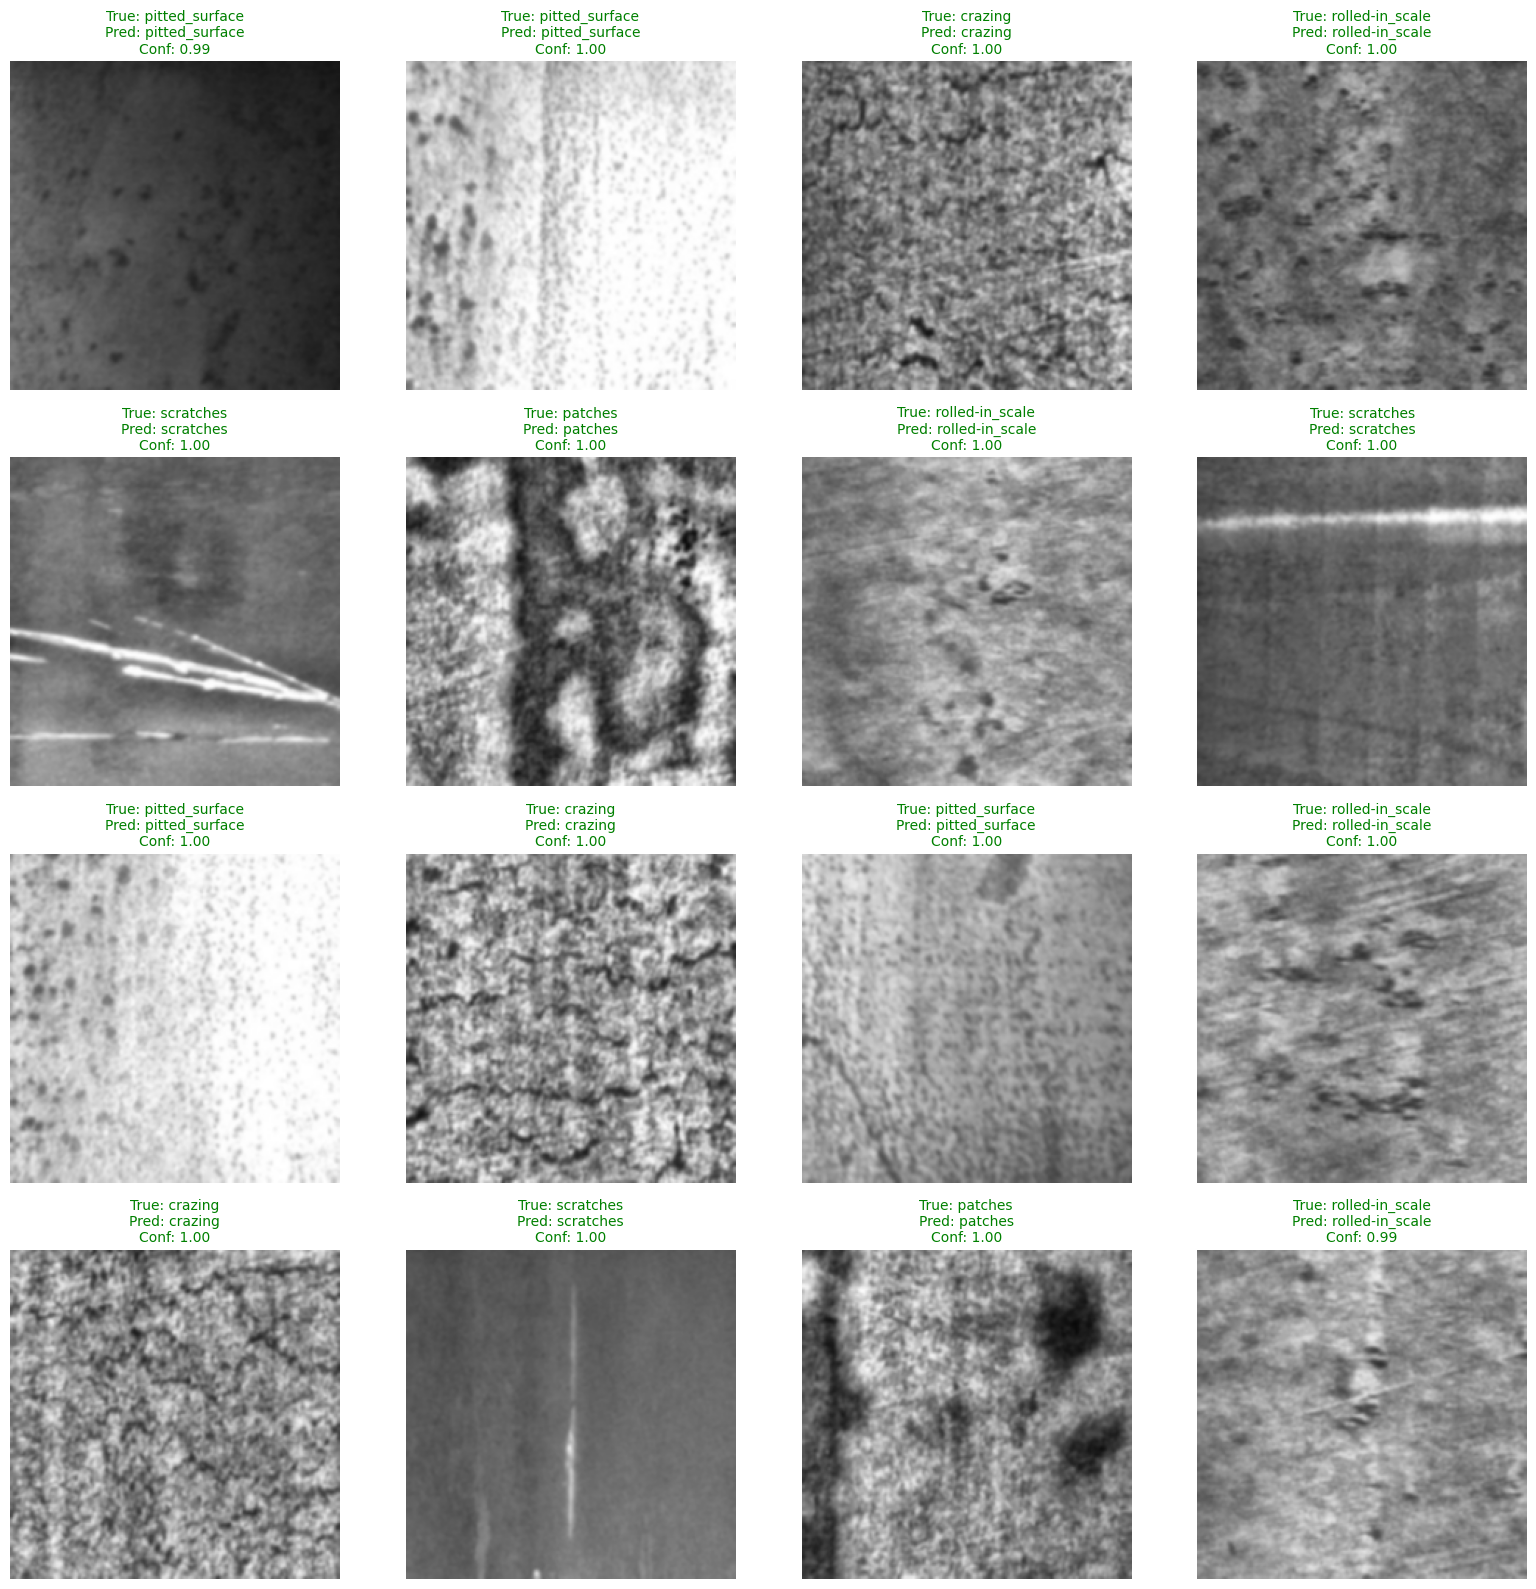


TRAINING COMPLETED!
All results saved to: /kaggle/outputs
Best model: MobileNetV2 with accuracy: 0.9963


In [27]:
# Visualize predictions cho model tốt nhất

# Ensure all_results is populated, load from file if necessary
if 'all_results' not in globals() or not all_results:
    try:
        with open(OUTPUT_DIR / 'all_results_summary.json', 'r') as f:
            all_results = json.load(f)
        print("Loaded all_results from file for visualization.")
    except FileNotFoundError:
        print("Error: all_results_summary.json not found. Please run model training first.")
        raise # Re-raise to stop execution if results are missing

best_model_name = max(all_results.items(), key=lambda x: x[1]['test_accuracy'])[0]
best_model = create_model(best_model_name, input_shape=(*IMG_SIZE, 3))
best_model.load_weights(OUTPUT_DIR / f"{best_model_name}_best.keras") # Corrected extension to .keras
visualize_predictions(best_model, X_test, y_test_cat, CLASSES)

print(f"\n{'='*100}")
print("TRAINING COMPLETED!")
print(f"All results saved to: {OUTPUT_DIR}")
print(f"Best model: {best_model_name} with accuracy: {all_results[best_model_name]['test_accuracy']:.4f}")
print(f"{'='*100}")

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [29]:
import os

drive_path = '/content/drive/MyDrive/CV_SEM'
kaggle_source_path = '/kaggle'

# Create the destination directory if it doesn't exist
os.makedirs(drive_path, exist_ok=True)

# Copy the entire /kaggle directory to the Google Drive destination
!cp -r {kaggle_source_path} {drive_path}

print(f"Successfully copied {kaggle_source_path} to {drive_path}")

Successfully copied /kaggle to /content/drive/MyDrive/CV_SEM
